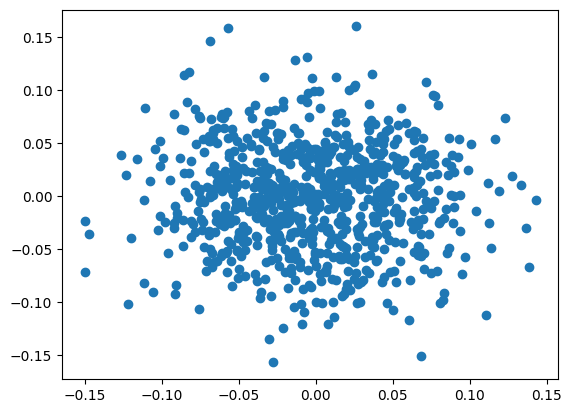

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

x = np.random.normal(0, 0.05, 800)
y = np.random.normal(0, 0.05, 800)
z = np.stack([x, y], axis=-1)
x_train = np.array(list(combinations(z, 2)))
y_train = []

for z1, z2 in x_train:
    y_train.append(
        [
            np.linalg.norm(z1),
            np.linalg.norm(z2),
            np.linalg.norm(z1 - z2),
        ]
    )

y_train = np.array(y_train)

plt.scatter(x, y)
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras import layers, optimizers, losses
from keras import saving


@saving.register_keras_serializable()
class Sigma(Model):
    def __init__(self, **kwargs):
        super(Sigma, self).__init__(**kwargs)
        self.encoder = SigmaEncoder()
        self.decoder = SigmaDecoder()

    def call(self, inputs):
        z = self.encoder(inputs)
        reconstructions = self.decoder(z)
        return reconstructions

    def compute_loss(self, x, y):
        z = self.encoder(x)
        recon = self.decoder(z)

        mean = tf.reduce_mean(z)
        std = tf.math.reduce_std(z)

        target_mean = 0
        target_std = (1 - 0.001) * tf.stop_gradient(std)

        kl_divergence = tf.reduce_mean(
            tf.math.log(target_std / std)
            + (tf.square(std) + tf.square(mean - target_mean))
            / (2 * tf.square(target_std))
            - 0.5
        )

        reconstruction_loss = tf.reduce_mean(tf.square(y - recon))
        return reconstruction_loss + 0.001 * kl_divergence, std

    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            loss, sigma = self.compute_loss(x, y)
            total_loss = loss

        trainable = self.trainable_variables
        gradients = tape.gradient(total_loss, trainable)
        self.optimizer.apply_gradients(zip(gradients, trainable))

        return {"loss": loss, "sigma": sigma}

    def get_config(self):
        config = super(Sigma, self).get_config()
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


def SigmaEncoder():
    inputs = layers.Input(shape=(2, 2))
    x = layers.Flatten()(inputs)
    x = layers.Dense(4, activation="relu")(x)
    output = layers.Dense(1)(x)
    return Model(inputs, output, name="Encoder")


def SigmaDecoder():
    inputs = layers.Input(shape=(1,))
    x = layers.Dense(4, activation="relu")(inputs)
    output = layers.Dense(3)(x)
    return Model(inputs, output, name="Decoder")


model = Sigma()
model.compile(optimizer=optimizers.Adam(), loss=losses.MeanSquaredError())
model.fit(x_train, y_train, epochs=10)
model.save("sigma.keras")

Epoch 1/10
9988/9988 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 6.9405e-04 - sigma: 0.0155
Epoch 2/10
9988/9988 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 6.1115e-04 - sigma: 0.0088
Epoch 3/10
9988/9988 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 6.1582e-04 - sigma: 0.0054
Epoch 4/10
9988/9988 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 6.1968e-04 - sigma: 0.0038
Epoch 5/10
9988/9988 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 6.2451e-04 - sigma: 0.0029
Epoch 6/10
9988/9988 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 6.2628e-04 - sigma: 0.0024
Epoch 7/10
9988/9988 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 6.2840e-04 - sigma: 0.0021
Epoch 8/10
9988/9988 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 6.2922e-04 - sigma: 0.0019
Epoch 9/10
9988/9988 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 6.2955e-04 - sigma: 0.0018
Epoch 10/10
9988/9988 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 6.2984e-04 - sigma: 0.0017


In [79]:
model = keras.models.load_model("sigma.keras", custom_objects={"sigma": Sigma})

2.8332459e-05 0.0016707964


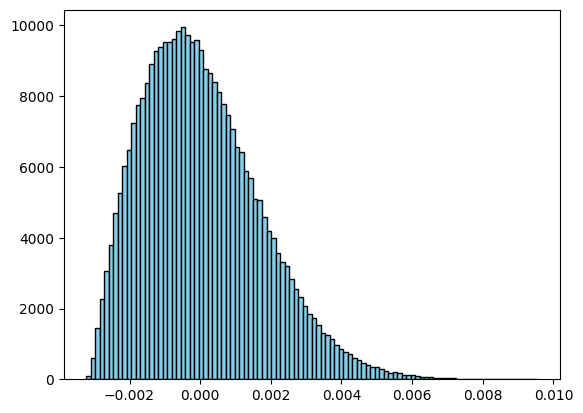

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

z = np.array(model.encoder(x_train))

mean, std = np.mean(z), np.std(z)
print(mean, std)
plt.hist(z, bins=100, color="skyblue", edgecolor="black")
plt.show()

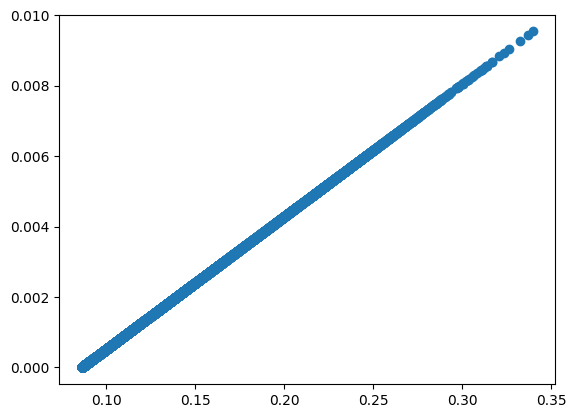

In [81]:
import numpy as np
import matplotlib.pyplot as plt

z = np.abs(np.array(model.encoder(x_train)))
d = np.array(model.decoder(z))[:, 2]

plt.scatter(d, z)
plt.show()